In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/df_eddies_processed_1462_10650.pkl')

with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)
    

In [2]:
sample_eddies = [474, 971, 1917, 1978, 33, 207, 1783, 2370]
dic_sample = {}
for eddy in sample_eddies:
    eddy = f'Eddy{eddy}'
    dic_sample[eddy] = dic_eddies_vert[eddy]
    

In [3]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


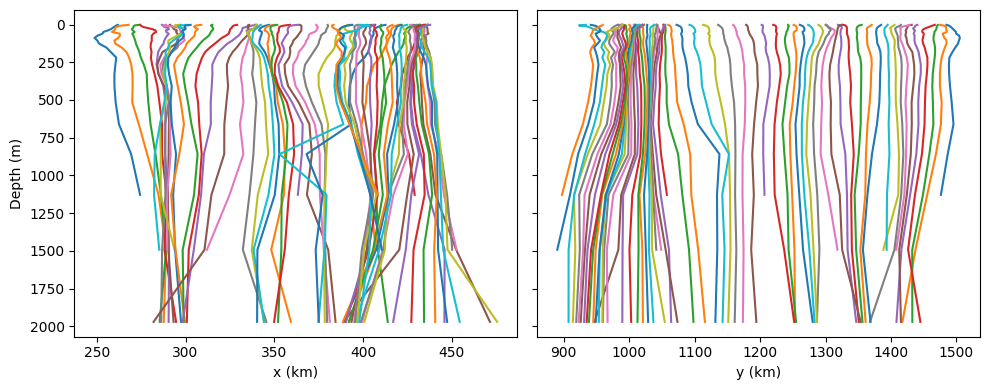

In [4]:
eddy = 474
dic = dic_sample[f'Eddy{eddy}']
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for day in dic.keys():
    df = dic[day].copy()
    df['Depth'] = -df['Depth']
    df = df[df['Depth'] <= 2000]
    axs[0].plot(df['x'], df['Depth'])
    axs[1].plot(df['y'], df['Depth'])
axs[0].set_xlabel('x (km)')
axs[1].set_xlabel('y (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].invert_yaxis()
plt.tight_layout()


### Delta Appraoch to Tilt

In [5]:
sample_eddies

[474, 971, 1917, 1978, 33, 207, 1783, 2370]

In [6]:
eddy   = 474
dic    = dic_sample[f'Eddy{eddy}']
num    = 6
depth_int = 10
max_depth = 1000

ref_day = 45  #45 

diffs_x = {}
diffs_y = {}

df_int = pd.DataFrame(columns=['Day', 'Depth', 'x', 'y'])

for d, day in enumerate(dic.keys()):
    if d >= ref_day - num // 2 and d <= ref_day + num // 2:
   
        df = dic[day].copy()
        df['Depth'] = -df['Depth']
        df = df[df['Depth'] <= max_depth]
        # don’t drop rows — keep all depths, even if x or y are NaN
        df = df.set_index('Depth').sort_index()
    
        depths       = df.index.values
        # interpolate at every 10 m from 0 to max_depth
        target_depths = np.arange(0, max_depth+1, depth_int)
        valid = target_depths[
            (target_depths >= depths.min()) &
            (target_depths <= depths.max())
        ]
        if len(valid) < 2:
            continue
    
        x_i = np.interp(valid, depths, df['x'].values)
        y_i = np.interp(valid, depths, df['y'].values)
    
        dx = np.diff(x_i)
        dy = np.diff(y_i)
    
        delta = np.hypot(dx, dy)
    
        # use the actual depth levels (valid[:-1]) as the Series index
        idx = valid[:-1]
    
        diffs_x[f'$t_{{{d}}}$'] = pd.Series(dx, index=idx)
        diffs_y[f'$t_{{{d}}}$'] = pd.Series(dy, index=idx)
    
        df = pd.DataFrame({'Day': day[3:], 'Depth': valid, 'x': x_i, 'y': y_i})
    
        if d == ref_day - num // 2:
            df_int = df
        else:
            df_int = pd.concat([df_int, df], ignore_index=True)

# now construct your DataFrames simply by passing the dict-of-series:
df_X = pd.DataFrame(diffs_x)
df_Y = pd.DataFrame(diffs_y)

# each df_X, df_Y will be indexed by the **union** of all depth-levels,
# with NaNs where a particular day didn’t have that depth.
df_X


,$t_{42}$,$t_{43}$,$t_{44}$,$t_{45}$,$t_{46}$,$t_{47}$,$t_{48}$
10,-0.051747,-1.638827,-2.159821,0.173483,0.297208,-0.824490,0.582713
20,0.671986,0.200463,-1.687845,0.095499,0.100146,-0.731935,0.312724
30,0.143292,0.825492,-0.252571,0.514087,0.133989,-0.532110,1.422681
40,0.065273,0.078020,0.233190,1.059272,0.267918,-0.375359,0.058524
50,0.134958,0.016538,-0.044793,0.092853,0.431094,0.464622,-0.482160
...,...,...,...,...,...,...,...
800,0.204521,0.201015,0.203050,0.179724,0.118266,0.054487,-0.019820
810,0.204521,0.201015,0.203050,0.179724,0.118266,0.054487,-0.019820
820,0.204521,0.201015,0.203050,0.179724,0.118266,0.054487,-0.019820
830,0.204521,0.201015,0.203050,0.179724,0.118266,0.054487,-0.019820


In [7]:
# Calculation of variability at each depth
df_data = pd.DataFrame()
df_data[r'$\Delta x$'] = df_X.mean(axis=1)
df_data[r'$\Delta y$'] = df_Y.mean(axis=1)
df_data[r'$\sum{\Delta x}$'] = df_data[r'$\Delta x$'].cumsum()
df_data[r'$\sum{\Delta y}$'] = df_data[r'$\Delta y$'].cumsum()
df_data[r'$\sigma^2_{\Delta x}$'] = df_X.std(axis=1)
df_data[r'$\sigma^2_{\Delta y}$'] = df_Y.std(axis=1)
df_data[r'Total $\sigma^2$'] = df_data[r'$\sigma^2_{\Delta x}$'] + df_data[r'$\sigma^2_{\Delta y}$']
df_data['weight'] = 1 / df_data[r'Total $\sigma^2$']
df_data['Depth'] = df_data.index 
df_data


,$\Delta x$,$\Delta y$,$\sum{\Delta x}$,$\sum{\Delta y}$,$\sigma^2_{\Delta x}$,$\sigma^2_{\Delta y}$,Total $\sigma^2$,weight,Depth
10,-0.517354,-1.384502,-0.517354,-1.384502,1.050193,1.406555,2.456748,0.407042,10
20,-0.148423,-1.219975,-0.665778,-2.604477,0.799900,1.225443,2.025343,0.493744,20
30,0.322123,-0.722576,-0.343655,-3.327053,0.661919,0.881179,1.543098,0.648047,30
40,0.198120,-0.175068,-0.145535,-3.502121,0.433613,0.814996,1.248609,0.800891,40
50,0.087588,-0.107441,-0.057948,-3.609562,0.318750,0.528906,0.847655,1.179725,50
...,...,...,...,...,...,...,...,...,...
800,0.134463,-0.063826,-0.933509,-5.649077,0.088083,0.045510,0.133593,7.485414,800
810,0.134463,-0.063826,-0.799045,-5.712904,0.088083,0.045510,0.133593,7.485414,810
820,0.134463,-0.063826,-0.664582,-5.776730,0.088083,0.045510,0.133593,7.485414,820
830,0.134463,-0.063826,-0.530119,-5.840556,0.088083,0.045510,0.133593,7.485414,830


In [8]:
# Line of Best Fit

# your data arrays of shape (N,)
x = df_data[r'$\sum{\Delta x}$'].values
y = df_data[r'$\sum{\Delta y}$'].values
z = df_data['Depth'].values
w = df_data['weight'].values

# 1. compute weighted mean
W = np.sum(w)
mean = np.array([np.dot(w, x),
                 np.dot(w, y),
                 np.dot(w, z)]) / W

# 2. center and weight the data
X = np.vstack((x, y, z)).T
Xc = X - mean
Xw = Xc * np.sqrt(w)[:, None]

# 3. SVD on weighted, centered data
_, _, Vt = np.linalg.svd(Xw, full_matrices=False)
direction = Vt[0]   # principal axis

# The best-fit line is:  p(t) = mean + t * direction
t = np.linspace((np.max(z)-mean[2])/direction[2], (np.min(z)-mean[2])/direction[2], 2)            # shape (100,)
p = mean[None, :] + t[:, None] * direction  # shape (100,3)
# or equivalently
p = mean + np.outer(t, direction)          # also (100,3)

# then split back out if you need x,y,z separately:
x_line, y_line, z_line = p.T


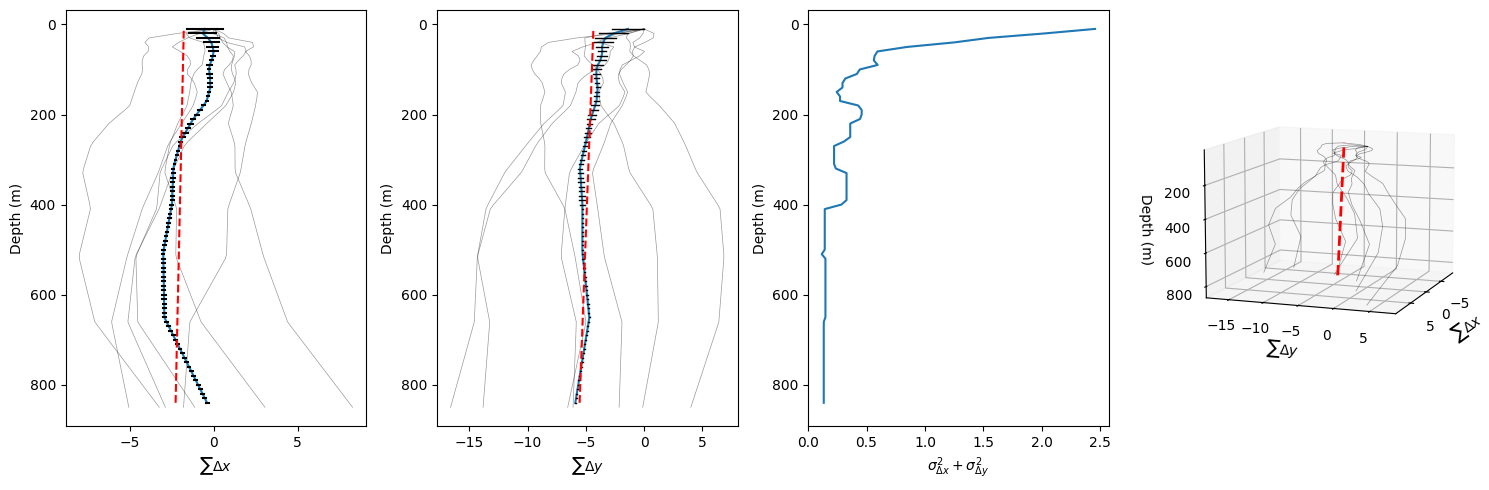

In [9]:
from mpl_toolkits.mplot3d import Axes3D  # registers the 3D projection

# set up figure with first two 2D and last one 3D
fig = plt.figure(figsize=(15, 5))

ax0 = fig.add_subplot(1, 4, 1)
ax1 = fig.add_subplot(1, 4, 2, sharey=ax0)
ax3 = fig.add_subplot(1, 4, 3, sharey=ax0)
ax2 = fig.add_subplot(1, 4, 4, projection='3d')

for day in df_int['Day'].unique():
    df = df_int[df_int['Day']==day]
    ax0.plot(df['x']-df.iloc[0]['x'], df['Depth'], alpha=.4, color='k', linewidth=.5)
    ax1.plot(df['y']-df.iloc[0]['y'], df['Depth'], alpha=.4, color='k', linewidth=.5)
    ax2.plot(df['x']-df.iloc[0]['x'], df['y']-df.iloc[0]['y'], df['Depth'],
             alpha=.4, color='k', linewidth=.5)

# — panel 1: sum{x} vs depth with error‐bars and line —
ax0.plot(df_data[r'$\sum{\Delta x}$'], df_data['Depth'], '-')
for k, depth in enumerate(df_data['Depth']):
    x0 = df_data.iloc[k][r'$\sum{\Delta x}$']
    r = df_data.iloc[k][r'$\sigma^2_{\Delta x}$']
    ax0.plot([x0 - r, x0 + r], [depth, depth], 'k-')
ax0.invert_yaxis()
ax0.plot(x_line, z_line, 'r--')
ax0.set_xlabel(r'$\sum\Delta  x$')
ax0.set_ylabel('Depth (m)')

# — panel 2: sum{y} vs depth —
ax1.plot(df_data[r'$\sum{\Delta y}$'], df_data['Depth'], '-')
for k, depth in enumerate(df_data['Depth']):
    y0 = df_data.iloc[k][r'$\sum{\Delta y}$']
    r = df_data.iloc[k][r'$\sigma^2_{\Delta y}$']
    ax1.plot([y0 - r, y0 + r], [depth, depth], 'k-', linewidth=1)
ax1.plot(y_line, z_line, 'r--')
ax1.set_xlabel(r'$\sum\Delta  y$')
ax1.set_ylabel('Depth (m)')

# # — panel 3: 3D circles + best‐fit line —
# theta = np.linspace(0, 2*np.pi, 100)
# for x0, y0, depth, r in zip(
#         df_data[r'$\sum{\Delta x}$'],
#         df_data[r'$\sum{\Delta y}$'],
#         df_data['Depth'],
#         df_data[r'Total $\sigma^2$']
#     ):
#     xs = x0 + r * np.cos(theta)
#     ys = y0 + r * np.sin(theta)
#     zs = np.full_like(theta, depth)
#     ax2.plot(xs, ys, zs, alpha=0.6)

# Plot volitility with depth
ax3.plot(df_data[r'Total $\sigma^2$'], df_data.Depth)
ax3.set_xlim(0, None)
ax3.set_ylabel('Depth (m)')
ax3.set_xlabel(r'$\sigma^2_{\Delta x} + \sigma^2_{\Delta y}$')

# plot best‐fit line in 3D
ax2.plot(x_line, y_line, z_line, 'r--', linewidth=2)

# invert the depth‐axis (z) so that increasing depth goes downwards
ax2.set_zlim(ax2.get_zlim()[::-1])

ax2.view_init(elev=10, azim=20)

ax2.set_xlabel(r'$\sum\Delta  x$')
ax2.set_ylabel(r'$\sum\Delta  y$')
ax2.set_zlabel('Depth (m)')

plt.tight_layout()
plt.show()


Text(0, 0.5, 'Depth (m)')

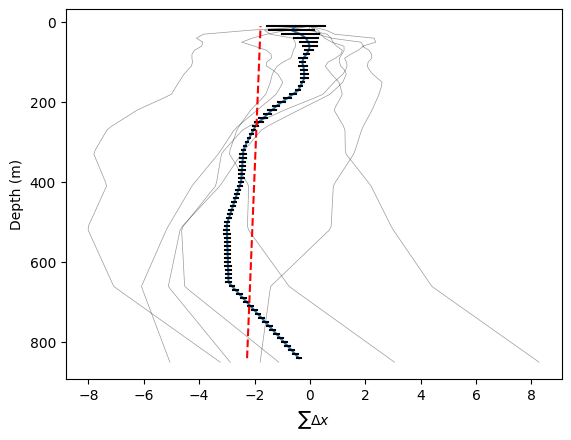

In [10]:
fig, ax0 = plt.subplots()

for day in df_int['Day'].unique():
    df = df_int[df_int['Day']==day]
    ax0.plot(df['x']-df.iloc[0]['x'], df['Depth'], alpha=.4, color='k', linewidth=.5)

ax0.plot(df_data[r'$\sum{\Delta x}$'], df_data['Depth'], '-')
for k, depth in enumerate(df_data['Depth']):
    x0 = df_data.iloc[k][r'$\sum{\Delta x}$']
    r = df_data.iloc[k][r'$\sigma^2_{\Delta x}$']
    ax0.plot([x0 - r, x0 + r], [depth, depth], 'k-')
ax0.invert_yaxis()
ax0.plot(x_line, z_line, 'r--')
ax0.set_xlabel(r'$\sum\Delta  x$')
ax0.set_ylabel('Depth (m)')


In [11]:
def bearing(a, b):
    dx = b[0] - a[0]
    dy = b[1] - a[1]
    angle_rad = np.arctan2(dx, dy)  # note the order: dx, dy
    angle_deg = np.degrees(angle_rad)
    bearing = (angle_deg + 360) % 360
    return bearing

tilt_dist = np.hypot(x_line[0]-x_line[1], y_line[0]-y_line[1])
tilt_dist

top_idx = np.where(np.abs(z_line)==np.min(np.abs(z_line)))[0][0]
if top_idx == 1:
    btm_idx = 0
else:
    btm_idx = 1
top = [x_line[top_idx], y_line[top_idx], z_line[top_idx]]
btm = [x_line[btm_idx], y_line[btm_idx], z_line[btm_idx]]
tilt_direc = ( bearing(btm, top) + 20 ) % 360
print(tilt_dist, tilt_direc)


1.2814904231193804 42.34026207164442


### Generalise

In [12]:
sample_eddies

[474, 971, 1917, 1978, 33, 207, 1783, 2370]

In [13]:
def compute_tilt_data(dic, eddy, num=6, depth_int=10, max_depth=1000):
    
    df_tilt_data = pd.DataFrame(columns=['Eddy', 'Day', 'TiltDis', 'TiltDir'])
    
    diffs_x = {}
    diffs_y = {}
        
    for d, day in enumerate(dic.keys()):
    
        df = dic[day].copy()
        df['Depth'] = -df['Depth']
        df = df[df['Depth'] <= max_depth]
        # don’t drop rows — keep all depths, even if x or y are NaN
        df = df.set_index('Depth').sort_index()

        if len(df):
        
            depths       = df.index.values
            # interpolate at every 10 m from 0 to max_depth
            target_depths = np.arange(0, max_depth+1, depth_int)
            valid = target_depths[
                (target_depths >= depths.min()) &
                (target_depths <= depths.max())
            ]
            if len(valid) < 2:
                continue
        
            x_i = np.interp(valid, depths, df['x'].values)
            y_i = np.interp(valid, depths, df['y'].values)
        
            dx = np.diff(x_i)
            dy = np.diff(y_i)
        
            # delta = np.hypot(dx, dy)
        
            # use the actual depth levels (valid[:-1]) as the Series index
            idx = valid[:-1]
        
            diffs_x[f'$t_{{{d}}}$'] = pd.Series(dx, index=idx)
            diffs_y[f'$t_{{{d}}}$'] = pd.Series(dy, index=idx)

        else:
            idx = [10]
            diffs_x[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            diffs_y[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            
    
    # now construct your DataFrames simply by passing the dict-of-series:
    df_X_all = pd.DataFrame(diffs_x)
    df_Y_all = pd.DataFrame(diffs_y)
    
    for ref_day in range(num //2, len(dic) - num //2):
    
        df_X = df_X_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
        df_Y = df_Y_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
        
        # Calculation of variability at each depth
        df_data = pd.DataFrame()
        df_data[r'$\Delta x$'] = df_X.mean(axis=1)
        df_data[r'$\Delta y$'] = df_Y.mean(axis=1)
        df_data[r'$\sum{\Delta x}$'] = df_data[r'$\Delta x$'].cumsum()
        df_data[r'$\sum{\Delta y}$'] = df_data[r'$\Delta y$'].cumsum()
        df_data[r'$\sigma^2_{\Delta x}$'] = df_X.std(axis=1)
        df_data[r'$\sigma^2_{\Delta y}$'] = df_Y.std(axis=1)
        df_data[r'Total $\sigma^2$'] = df_data[r'$\sigma^2_{\Delta x}$'] + df_data[r'$\sigma^2_{\Delta y}$']
        df_data['weight'] = 1 / df_data[r'Total $\sigma^2$']
        df_data['Depth'] = df_data.index 
        df_data
        
        # Line of Best Fit
        
        # your data arrays of shape (N,)
        x = df_data[r'$\sum{\Delta x}$'].values
        y = df_data[r'$\sum{\Delta y}$'].values
        z = df_data['Depth'].values
        w = df_data['weight'].values
        
        # 1. compute weighted mean
        W = np.sum(w)
        mean = np.array([np.dot(w, x),
                         np.dot(w, y),
                         np.dot(w, z)]) / W
        
        # 2. center and weight the data
        X = np.vstack((x, y, z)).T
        Xc = X - mean
        Xw = Xc * np.sqrt(w)[:, None]
        
        # 3. SVD on weighted, centered data
        try:
            flag = 0
            _, _, Vt = np.linalg.svd(Xw, full_matrices=False)
        except Exception:
            flag = 1
            print(f"Eddy{eddy} on day {list(dic_sample[f'Eddy{eddy}'].keys())[ref_day][3:]} did not have a measurable profile")
            
        if flag:
            
            df_tilt_data.loc[len(df_tilt_data)] = {'Eddy': eddy, 'Day': list(dic_sample[f'Eddy{eddy}'].keys())[ref_day][3:], 'TiltDis': np.nan, 'TiltDir': np.nan}
            
        else:
            
            direction = Vt[0]   # principal axis
            
            # The best-fit line is:  p(t) = mean + t * direction
            t = np.linspace((np.max(z)-mean[2])/direction[2], (np.min(z)-mean[2])/direction[2], 2)            # shape (100,)
            p = mean[None, :] + t[:, None] * direction  # shape (100,3)
            # or equivalently
            p = mean + np.outer(t, direction)          # also (100,3)
            
            # then split back out if you need x,y,z separately:
            x_line, y_line, z_line = p.T
            
            tilt_dist = np.hypot(x_line[0]-x_line[1], y_line[0]-y_line[1])
            
            top_idx = np.where(np.abs(z_line)==np.min(np.abs(z_line)))[0][0]
            if top_idx == 1:
                btm_idx = 0
            else:
                btm_idx = 1
            top = [x_line[top_idx], y_line[top_idx], z_line[top_idx]]
            btm = [x_line[btm_idx], y_line[btm_idx], z_line[btm_idx]]
            tilt_direc = ( bearing(btm, top) + 20 ) % 360
        
            df_tilt_data.loc[len(df_tilt_data)] = {'Eddy': eddy, 'Day': list(dic_sample[f'Eddy{eddy}'].keys())[ref_day][3:], 'TiltDis': tilt_dist, 'TiltDir': tilt_direc}
        
    return df_tilt_data


In [14]:
eddy   = 474
dic    = dic_sample[f'Eddy{eddy}']

df_tilt_data = compute_tilt_data(dic, eddy)
df_tilt_data


,Eddy,Day,TiltDis,TiltDir
0,474,2905,9.064814,314.672663
1,474,2906,6.758671,314.869709
2,474,2907,3.040681,299.307447
3,474,2908,0.558524,252.650096
4,474,2909,0.554670,89.223484
5,474,2910,1.312592,71.374003
6,474,2911,1.683392,102.567835
7,474,2912,3.244421,128.403026
8,474,2913,5.169392,127.132398
9,474,2914,5.298059,109.370382


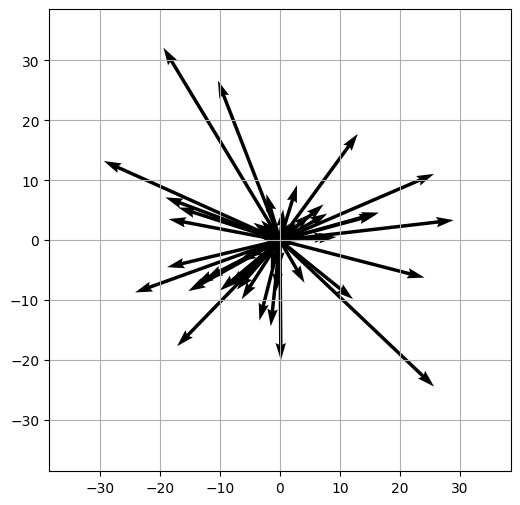

In [15]:
df = df_tilt_data.copy().dropna()

r = df['TiltDis'].values
theta = df['TiltDir'].values

u = r * np.cos(theta)  # x-component
v = r * np.sin(theta)  # y-component

# Plot quiver from the origin (0, 0)
plt.figure(figsize=(6, 6))
plt.quiver(np.zeros_like(r), np.zeros_like(r), u, v, angles='xy', scale_units='xy', scale=1)
plt.xlim(-max(r)-1, max(r)+1)
plt.ylim(-max(r)-1, max(r)+1)
plt.gca().set_aspect('equal')
plt.grid(True)
plt.show()


#### Sample plot

In [16]:
df_tilt_data_all = pd.DataFrame()
for eddy in sample_eddies:
    dic = dic_sample[f'Eddy{eddy}']
    df_tilt_data = compute_tilt_data(dic, eddy)
    df_tilt_data_all = pd.concat([df_tilt_data_all, df_tilt_data], ignore_index=True)
    

Eddy33 on day 1593 did not have a measurable profile
Eddy33 on day 1594 did not have a measurable profile
Eddy33 on day 1595 did not have a measurable profile
Eddy33 on day 1596 did not have a measurable profile
Eddy1783 on day 7054 did not have a measurable profile
Eddy1783 on day 7055 did not have a measurable profile
Eddy1783 on day 7056 did not have a measurable profile


In [17]:
colors = [c for i, c in enumerate(plt.get_cmap("tab10").colors) if i != 7]

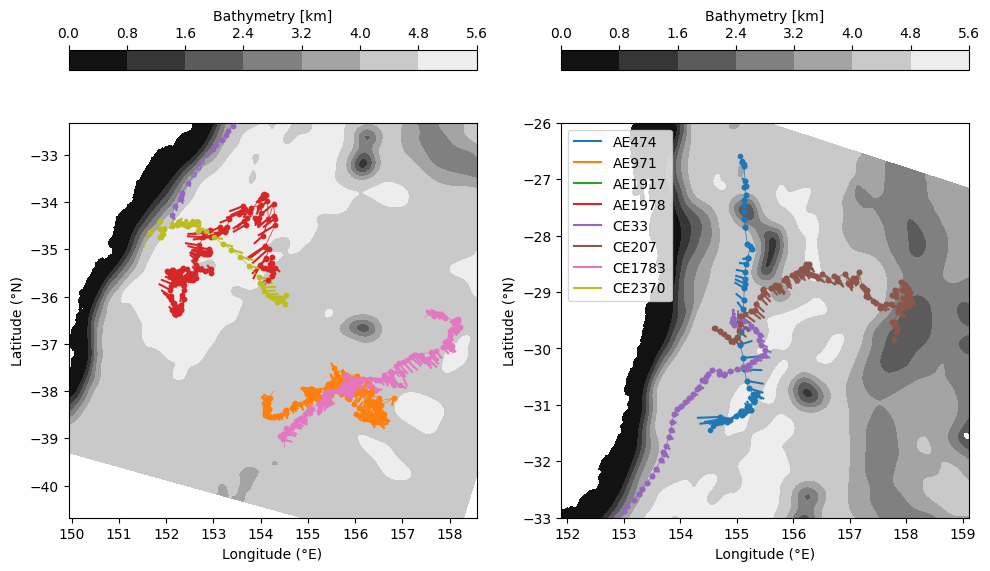

In [18]:
def point_b(a, r, theta_deg):
    theta_rad = np.radians(theta_deg)
    dx = r * np.cos(theta_rad)
    dy = r * np.sin(theta_rad)
    return a[0] + dx, a[1] + dy

def km_to_deg(km, lat, bearing_deg):
    lat_rad = np.radians(lat)
    bearing_rad = np.radians(bearing_deg)

    # km per degree
    km_per_deg_lat = 111.32
    km_per_deg_lon = 111.32 * np.cos(lat_rad)

    # project distance onto lat/lon directions
    dlat = km * np.sin(bearing_rad) / km_per_deg_lat
    dlon = km * np.cos(bearing_rad) / km_per_deg_lon

    # total angular distance in degrees
    return np.hypot(dlat, dlon)

fig, axs = plt.subplots(1, 2, figsize=(10,6))
cf0 = axs[0].contourf(lon_rho, lat_rho, np.where(mask_rho, h/1000, np.nan), cmap='gray')
cf1 = axs[1].contourf(lon_rho, lat_rho, np.where(mask_rho, h/1000, np.nan), cmap='gray')
# Add horizontal colorbars at the top
fig.colorbar(cf0, ax=axs[0], orientation='horizontal', location='top', pad=0.1, label='Bathymetry [km]')
fig.colorbar(cf1, ax=axs[1], orientation='horizontal', location='top', pad=0.1, label='Bathymetry [km]')

for e, eddy in enumerate(df_tilt_data_all['Eddy'].unique()):
    df = df_tilt_data_all[df_tilt_data_all['Eddy']==eddy]
    df_eddy = df_eddies[df_eddies.Eddy==eddy]
    axs[0].plot(df_eddy['Lon'], df_eddy['Lat'], color=colors[e], linewidth=.5)
    axs[1].plot(df_eddy['Lon'], df_eddy['Lat'], color=colors[e], linewidth=.5, marker='.')
    for d, day in enumerate(df['Day'].unique()):
        data = df[df['Day']==day]
        tilt_dis = data.iloc[0]['TiltDis']
        tilt_dir = data.iloc[0]['TiltDir']
        plot_data = df_eddies[(df_eddies.Eddy==eddy) & (df_eddies['Day']==int(day))]
        elon, elat = plot_data.iloc[0]['Lon'], plot_data.iloc[0]['Lat']
        lon_btm, lat_btm = point_b([elon, elat], km_to_deg(tilt_dis, elat, (tilt_dir + 180) % 360), (tilt_dir + 180) % 360)
        axs[0].plot([elon, lon_btm], [elat, lat_btm], color=colors[e], zorder=2)
        cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0]['Cyc']
        axs[1].plot([elon, lon_btm], [elat, lat_btm], color=colors[e], zorder=2, label=f'{cyc}{eddy}' if d==0 else '')
        if np.isnan(tilt_dis):
            axs[0].scatter(elon, elat, color=colors[e], s=10, zorder=3, facecolors='none')#, edgecolor='k')
            axs[1].scatter(elon, elat, color=colors[e], s=10, zorder=3, facecolors='none')#, edgecolor='k')
        else:
            axs[0].scatter(elon, elat, color=colors[e], s=10, zorder=3)#, edgecolor='k')
            axs[1].scatter(elon, elat, color=colors[e], s=10, zorder=3)#, edgecolor='k')
axs[0].axis('equal')
axs[0].set_xlim(150, 158.5)
axs[0].set_ylim(-40, -33)
axs[0].set_xlabel('Longitude (°E)')
axs[0].set_ylabel('Latitude (°N)')

axs[1].axis('equal')
axs[1].set_ylim(-33, -26)
axs[1].set_xlim(152, 159)
axs[1].set_xlabel('Longitude (°E)')
axs[1].set_ylabel('Latitude (°N)')
axs[1].legend()

plt.tight_layout()


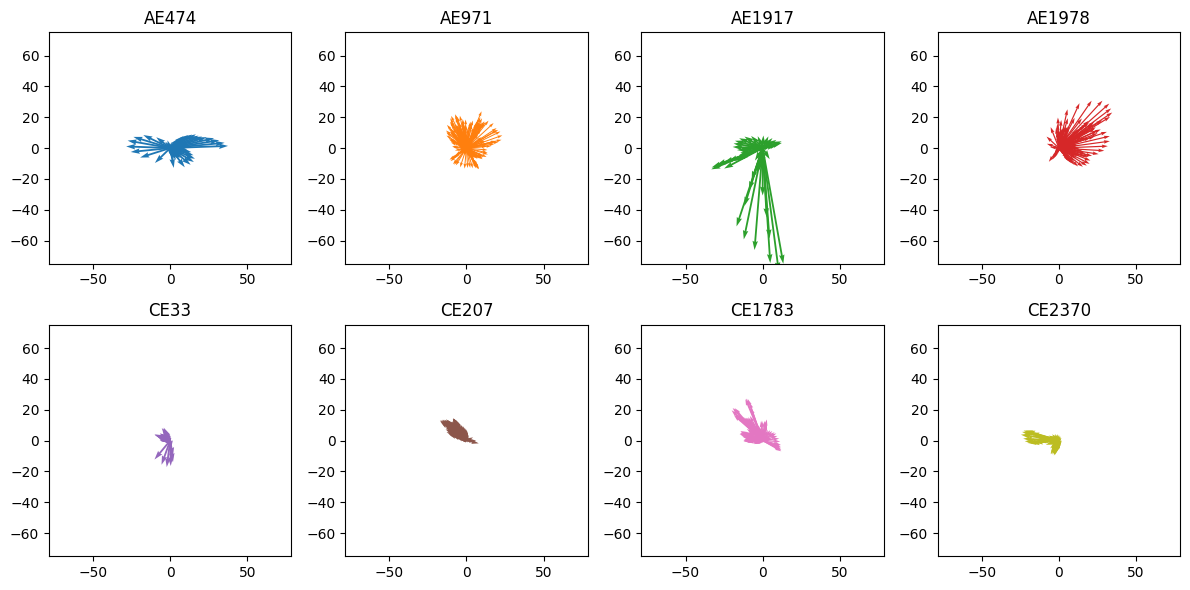

In [19]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))

xabs = 0
for e, eddy in enumerate(df_tilt_data_all['Eddy'].unique()):
    ax = axs[e // 4, e % 4]

    df = df_tilt_data_all[df_tilt_data_all['Eddy'] == eddy].dropna()
    r = df['TiltDis'].values
    theta = np.radians(df['TiltDir'].values)  # convert to radians if in degrees

    u = r * np.cos(theta)
    v = r * np.sin(theta)

    ax.quiver(np.zeros_like(r), np.zeros_like(r), u, v, angles='xy', scale_units='xy', scale=1, color=colors[e])
    max_r = max(r) if len(r) > 0 else 1
    ax.axis('equal')
    ax.set_xlim(-max_r - 1, max_r + 1)
    ax.set_ylim(-max_r - 1, max_r + 1)
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0]['Cyc']
    ax.set_title(f"{cyc}{eddy}")

    xabs = max(xabs, np.abs(ax.get_xlim()[0]), np.abs(ax.get_xlim()[1]), np.abs(ax.get_ylim()[0]), np.abs(ax.get_ylim()[1]))
    
for ax in axs.flat:
    ax.set_xlim(-xabs, xabs)
    ax.set_ylim(-xabs, xabs)

plt.tight_layout()


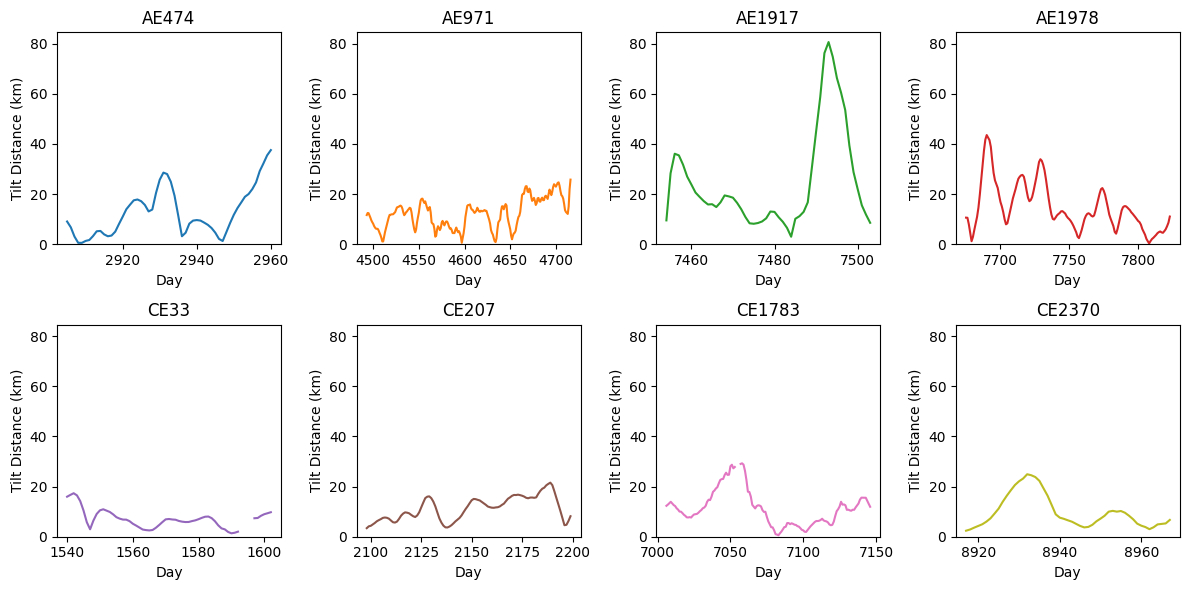

In [20]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))

ymax = 0
for e, eddy in enumerate(df_tilt_data_all['Eddy'].unique()):
    ax = axs[e // 4, e % 4]

    df = df_tilt_data_all[df_tilt_data_all['Eddy'] == eddy].copy()
    ax.plot([int(d) for d in df['Day'].values], df['TiltDis'], color=colors[e])
    ymax = max(ymax, ax.get_ylim()[1])
    cyc = df_eddies.loc[df_eddies.Eddy == eddy, 'Cyc'].iat[0]
    ax.set_title(f"{cyc}{eddy}")
for ax in axs.flat:
    ax.set_ylim(0, ymax)
    ax.set_ylabel('Tilt Distance (km)')
    ax.set_xlabel('Day')
plt.tight_layout()    


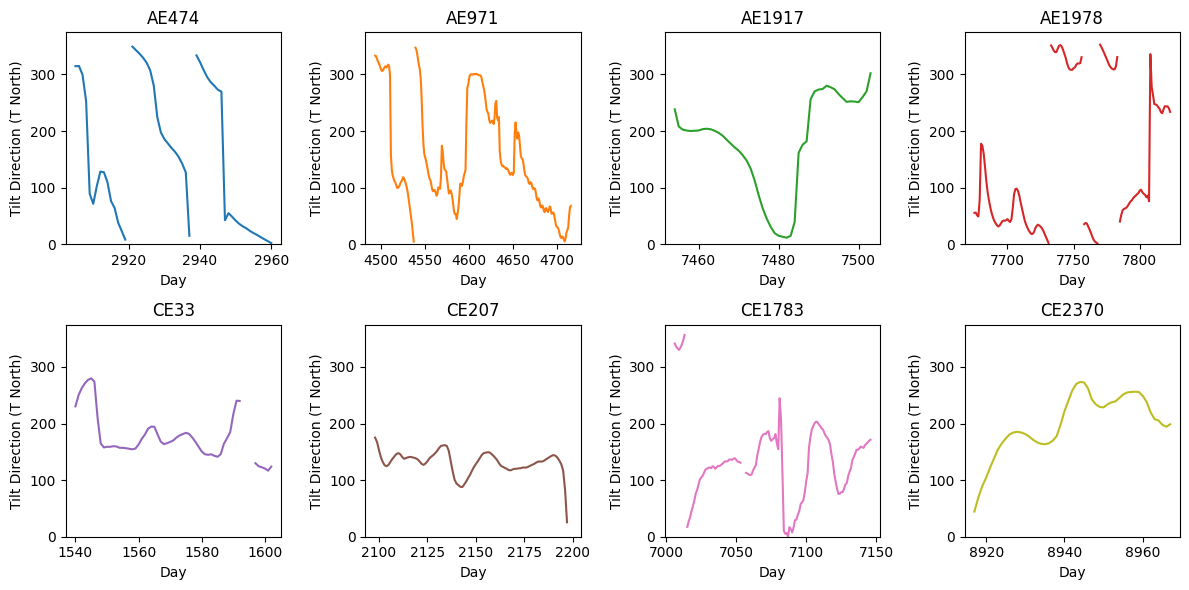

In [33]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))

ymax = 0
for e, eddy in enumerate(df_tilt_data_all['Eddy'].unique()):
    ax = axs[e // 4, e % 4]

    df = df_tilt_data_all[df_tilt_data_all['Eddy'] == eddy].copy()
    TDir = df['TiltDir'].copy()
    TDir[TDir.diff().abs()>300] = np.nan
    ax.plot([int(d) for d in df['Day'].values], TDir, color=colors[e])
    ymax = max(ymax, ax.get_ylim()[1])
    cyc = df_eddies.loc[df_eddies.Eddy == eddy, 'Cyc'].iat[0]
    ax.set_title(f"{cyc}{eddy}")
for ax in axs.flat:
    ax.set_ylim(0, ymax)
    ax.set_ylabel('Tilt Direction (T North)')
    ax.set_xlabel('Day')
plt.tight_layout()    


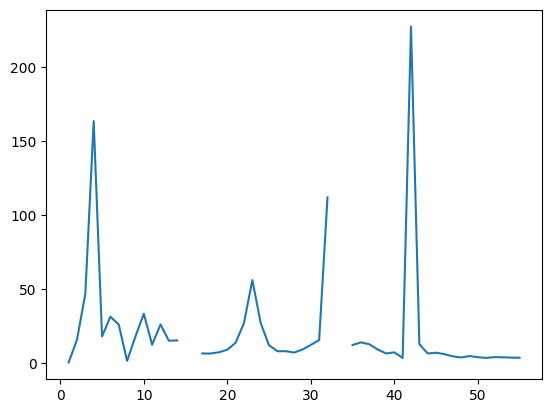

In [31]:
 df = df_tilt_data_all[df_tilt_data_all['Eddy'] == 474].copy()
TDir = df['TiltDir'].copy()
TDir[TDir.diff().abs()>300] = np.nan
plt.plot(TDir.diff().abs())